# NFL rankings through time

In this notebook, we aim to establish NFL rankings over the course of the past 20 years, using a modified version of the ELO scoring framework from chess.

To do this, we borrowed some code from https://github.com/HankSheehan/EloPy and modified it using some intuitive ideas introduced in https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/.

Let's get started.

### Imports

Like any good project, we'll import *pandas*, *numpy*, and *matplotlib.pyplot* immediately.

We'll also use *requests*, *bs4*, and *re* to scrape the data from the web and clean it up a bit.

*ParameterGrid* from *sklearn.model_selection* will be used to determine if any specific set of parameters yields the best results when predicting game outcomes.

*ipywidgets* and *plotly* will be used to make some plots that we can interact with.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import bs4
import re

from sklearn.model_selection import ParameterGrid

import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go

### Getting the data

Using a little bit of regex, we'll read in data from each week of NFL games since 2002. You'll notice the Super Bowl data is stored a little differently, so we'll modify our regex to get that data too.

In [2]:
games_df = pd.DataFrame(columns = ['year', 'week', 'dow', 'dt', 'tm', 'n0' ,'n1', 'away', 'n2', 'n3', 'away_pts', 'n4', 'home_pts', 'n5', 'n6', 'home'])

for year in range(2002, 2021):
    for week in range(1,22):
        url = 'https://nflgamedata.com/schedule.php?season={0}&week={1}'.format(year, week)
        text_nfl = requests.get(url).text
        
        soup_gamestats = bs4.BeautifulSoup(text_nfl)
        
        stats_tables =  soup_gamestats.find_all('table')
        
        stats_table_rows = stats_tables[2].find_all('tr')

        stats_data_rows = []
        for tr in stats_table_rows:
            tds = tr.find_all('td')
            row = [td.text for td in tds]
            if row:
                stats_data_rows.append(row)
        
        text = str(stats_data_rows)
        if week != 21:
            matches  = re.findall(\
                "'[A-Z]{3}', '[0-9]+\/[0-9]+', '[0-9]+:[0-9]+', '', '', '[A-Z]{2,3}', '', '', '[0-9]+', '@\\\\[a-z]', '[0-9]+', '', '', '[A-Z]{2,3}'",
                text)
        else:
            matches  = re.findall(\
                "'[A-Z]{3}', '[0-9]+\/[0-9]+', '[0-9]+:[0-9]+', '', '', '[A-Z]{2,3}', '', '', '[0-9]+', 'vs\.\\\\n', '[0-9]+', '', '', '[A-Z]{2,3}'",
                text)
        
        for match in matches:
            games_df.loc[len(games_df)] = [year, week] + match.replace('"', '').replace("'", '').replace(" ", '').split(',')

### Clean up

We were bit lazy in reading things in. We grabbed some extra columns and some extra characters that we'll want to get rid of. We'll also want to be sure we have the data types we are actually interested in working with.

Since some teams moved geographic locations, but were still technically the same team, we'll need to clean the home and away columns too.

In [3]:
games_df = games_df[['year', 'week', 'dow', 'dt', 'tm', 'home', 'away', 'home_pts', 'away_pts']]
games_df = games_df.drop_duplicates()

games_df.year = games_df.year.astype(int)
games_df.week = games_df.week.astype(int)

games_df.home_pts = games_df.home_pts.astype(int)
games_df.away_pts = games_df.away_pts.astype(int)

games_df['month'] = games_df.dt.str.split('/').apply(lambda x: x[0])
games_df['day'] = games_df.dt.str.split('/').apply(lambda x: x[1])

games_df.home = games_df.home.replace('OAK', 'LV')
games_df.away = games_df.away.replace('OAK', 'LV')

games_df.home = games_df.home.replace('SD', 'LAC')
games_df.away = games_df.away.replace('SD', 'LAC')

games_df.home = games_df.home.replace('STL', 'LA')
games_df.away = games_df.away.replace('STL', 'LA')

games_df = games_df.sort_values(['year', 'week', 'month', 'day'])

games_df.to_csv('nfl_game_data.csv')

### Tune parameters

We modified the code a bit to allow for parameters, but are not exactly sure about the optimal values.

Specifically, how much weight should home field advantage be given?
How much more should a blow out victory count vs. a closer game?
How much of a team's ranking should carry over into the next season?
How sensitive to an individual win should the rating system be?

Let's find out.

In [4]:
param_grid = {'home_adv': [0, 60, 120], 'margin_div':[1,10,100],
              'season_retain_weight': [.25, .5, .75], 'k_val': [10, 20, 40]}

In [5]:
result = pd.DataFrame(columns = ['row', 'pct_correct'])

for i in range(len(list(ParameterGrid(param_grid)))):
    home_adv = list(ParameterGrid(param_grid))[i]['home_adv']
    margin_div = list(ParameterGrid(param_grid))[i]['margin_div']
    season_retain_weight = list(ParameterGrid(param_grid))[i]['season_retain_weight']
    k_val = list(ParameterGrid(param_grid))[i]['k_val']
    
    class Implementation:
        """
        A class that represents an implementation of the Elo Rating System
        """

        def __init__(self, base_rating=1500):
            """
            Runs at initialization of class object.
            @param base_rating - The rating a new player would have
            """
            self.base_rating = base_rating
            self.players = []

        def __getPlayerList(self):
            """
            Returns this implementation's player list.
            @return - the list of all player objects in the implementation.
            """
            return self.players

        def getPlayer(self, name):
            """
            Returns the player in the implementation with the given name.
            @param name - name of the player to return.
            @return - the player with the given name.
            """
            for player in self.players:
                if player.name == name:
                    return player
            return None

        def contains(self, name):
            """
            Returns true if this object contains a player with the given name.
            Otherwise returns false.
            @param name - name to check for.
            """
            for player in self.players:
                if player.name == name:
                    return True
            return False

        def addPlayer(self, name, rating=None):
            """
            Adds a new player to the implementation.
            @param name - The name to identify a specific player.
            @param rating - The player's rating.
            """
            if rating == None:
                rating = self.base_rating

            self.players.append(_Player(name=name,rating=rating))

        def removePlayer(self, name):
            """
            Adds a new player to the implementation.
            @param name - The name to identify a specific player.
            """
            self.__getPlayerList().remove(self.getPlayer(name))


        def recordMatch(self, name1, name2, winner=None, draw=False, margin=None):
            """
            Should be called after a game is played.
            @param name1 - name of the first player.
            @param name2 - name of the second player.
            """
            player1 = self.getPlayer(name1)
            player2 = self.getPlayer(name2)

            expected1 = player1.compareRating(player2, home = True)
            expected2 = player2.compareRating(player1, home = False)

            k = k_val

            rating1 = player1.rating
            rating2 = player2.rating

            if draw:
                score1 = 0.5
                score2 = 0.5
            elif winner == name1:
                score1 = 1.0
                score2 = 0.0
            elif winner == name2:
                score1 = 0.0
                score2 = 1.0
            else:
                raise InputError('One of the names must be the winner or draw must be True')

            if draw:
                newRating1 = rating1 + k * (score1 - expected1)
                newRating2 = rating2 + k * (score2 - expected2)
            else:
                newRating1 = rating1 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score1 - expected1)
                newRating2 = rating2 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score2 - expected2)


            if newRating1 < 0:
                newRating1 = 0
                newRating2 = rating2 - rating1

            elif newRating2 < 0:
                newRating2 = 0
                newRating1 = rating1 - rating2

            player1.rating = newRating1
            player2.rating = newRating2

        def getPlayerRating(self, name):
            """
            Returns the rating of the player with the given name.
            @param name - name of the player.
            @return - the rating of the player with the given name.
            """
            player = self.getPlayer(name)
            return player.rating

        def getRatingList(self):
            """
            Returns a list of tuples in the form of ({name},{rating})
            @return - the list of tuples
            """
            lst = []
            for player in self.__getPlayerList():
                lst.append((player.name,player.rating))
            return lst

    class _Player:
        """
        A class to represent a player in the Elo Rating System
        """

        def __init__(self, name, rating):
            """
            Runs at initialization of class object.
            @param name - TODO
            @param rating - TODO
            """
            self.name = name
            self.rating = rating

        def compareRating(self, opponent, home):
            """
            Compares the two ratings of the this player and the opponent.
            @param opponent - the player to compare against.
            @returns - The expected score between the two players.
            """
            if home == True:
                return ( 1+10**( ( opponent.rating-self.rating-home_adv )/400.0 ) ) ** -1
            else:
                return ( 1+10**( ( opponent.rating-self.rating+home_adv )/400.0 ) ) ** -1

    games_count_df = pd.DataFrame(columns=games_df.home.unique())
    games_count_df.loc[0] = [0 for col in games_count_df.columns]

    game_elo_df = pd.DataFrame(columns=games_df.home.unique())

    uni = Implementation()


    for team in games_df.home.unique():
        uni.addPlayer(name = team)

    total = 0
    correct = 0
    for season in games_df.year.unique():
        for week in games_df.week.unique():
            for ind in games_df[(games_df.year==season) & (games_df.week==week)].index:
                home = games_df.loc[ind, 'home']
                away = games_df.loc[ind, 'away']

                home_elo = uni.getPlayerRating(home)
                away_elo = uni.getPlayerRating(away)
                if home_elo > away_elo:
                    pred = home
                else:
                    pred = away

                games_count_df.loc[0, home] = games_count_df.loc[0, home]+1
                games_count_df.loc[0, away] = games_count_df.loc[0, away]+1

                margin = games_df.loc[ind, 'home_pts'] - games_df.loc[ind, 'away_pts']

                if margin > 0:
                    winner = home
                elif margin < 0:
                    winner = away
                    margin *= -1
                else:
                    winner = 'tie'

                if winner == 'tie':
                    uni.recordMatch(home, away, draw=True)
                else:
                    uni.recordMatch(home, away, winner, margin=margin)

                total += 1
                if pred == winner:
                    correct += 1

                game_elo_df.loc[games_count_df.loc[0, home], home] = uni.getPlayerRating(home)
                game_elo_df.loc[games_count_df.loc[0, away], away] = uni.getPlayerRating(away)

        games_count_df.loc[0] = [games_count_df.max().max() for col in games_count_df.columns]
    
        for team in games_df.home.unique():
                uni.getPlayer(team).rating = (season_retain_weight * uni.getPlayerRating(team)) +\
                    ((1-season_retain_weight) * 1500)
    result.loc[i] = [i, correct/total]

How do the different sets of parameters stack up?

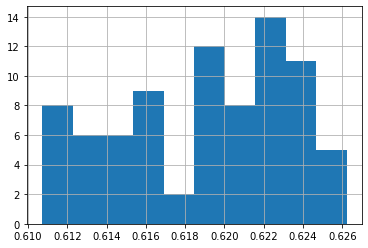

In [6]:
result.pct_correct.hist()

There is not much difference among results.

Keep in mind, this was just optimizing for accuracy in picking winners. In reality, there is also a point spread to consider. These ratings are not quite ready for Vegas, despite how accurate they are.

Still, what were our top parameters?

In [7]:
best = result.pct_correct.idxmax()
list(ParameterGrid(param_grid))[best]

{'home_adv': 0, 'k_val': 20, 'margin_div': 1, 'season_retain_weight': 0.5}

### Using the top performing parameters

Let's put them to use.

In [8]:
home_adv = list(ParameterGrid(param_grid))[best]['home_adv']
margin_div = list(ParameterGrid(param_grid))[best]['margin_div']
season_retain_weight = list(ParameterGrid(param_grid))[best]['season_retain_weight']
k_val = list(ParameterGrid(param_grid))[best]['k_val']

class Implementation:
    """
    A class that represents an implementation of the Elo Rating System
    """

    def __init__(self, base_rating=1500):
        """
        Runs at initialization of class object.
        @param base_rating - The rating a new player would have
        """
        self.base_rating = base_rating
        self.players = []

    def __getPlayerList(self):
        """
        Returns this implementation's player list.
        @return - the list of all player objects in the implementation.
        """
        return self.players

    def getPlayer(self, name):
        """
        Returns the player in the implementation with the given name.
        @param name - name of the player to return.
        @return - the player with the given name.
        """
        for player in self.players:
            if player.name == name:
                return player
        return None

    def contains(self, name):
        """
        Returns true if this object contains a player with the given name.
        Otherwise returns false.
        @param name - name to check for.
        """
        for player in self.players:
            if player.name == name:
                return True
        return False

    def addPlayer(self, name, rating=None):
        """
        Adds a new player to the implementation.
        @param name - The name to identify a specific player.
        @param rating - The player's rating.
        """
        if rating == None:
            rating = self.base_rating

        self.players.append(_Player(name=name,rating=rating))

    def removePlayer(self, name):
        """
        Adds a new player to the implementation.
        @param name - The name to identify a specific player.
        """
        self.__getPlayerList().remove(self.getPlayer(name))


    def recordMatch(self, name1, name2, winner=None, draw=False, margin=None):
        """
        Should be called after a game is played.
        @param name1 - name of the first player.
        @param name2 - name of the second player.
        """
        player1 = self.getPlayer(name1)
        player2 = self.getPlayer(name2)

        expected1 = player1.compareRating(player2, home = True)
        expected2 = player2.compareRating(player1, home = False)

        k = k_val

        rating1 = player1.rating
        rating2 = player2.rating

        if draw:
            score1 = 0.5
            score2 = 0.5
        elif winner == name1:
            score1 = 1.0
            score2 = 0.0
        elif winner == name2:
            score1 = 0.0
            score2 = 1.0
        else:
            raise InputError('One of the names must be the winner or draw must be True')

        if draw:
            newRating1 = rating1 + k * (score1 - expected1)
            newRating2 = rating2 + k * (score2 - expected2)
        else:
            newRating1 = rating1 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score1 - expected1)
            newRating2 = rating2 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score2 - expected2)


        if newRating1 < 0:
            newRating1 = 0
            newRating2 = rating2 - rating1

        elif newRating2 < 0:
            newRating2 = 0
            newRating1 = rating1 - rating2

        player1.rating = newRating1
        player2.rating = newRating2

    def getPlayerRating(self, name):
        """
        Returns the rating of the player with the given name.
        @param name - name of the player.
        @return - the rating of the player with the given name.
        """
        player = self.getPlayer(name)
        return player.rating

    def getRatingList(self):
        """
        Returns a list of tuples in the form of ({name},{rating})
        @return - the list of tuples
        """
        lst = []
        for player in self.__getPlayerList():
            lst.append((player.name,player.rating))
        return lst

class _Player:
    """
    A class to represent a player in the Elo Rating System
    """

    def __init__(self, name, rating):
        """
        Runs at initialization of class object.
        @param name - TODO
        @param rating - TODO
        """
        self.name = name
        self.rating = rating

    def compareRating(self, opponent, home):
        """
        Compares the two ratings of the this player and the opponent.
        @param opponent - the player to compare against.
        @returns - The expected score between the two players.
        """
        if home == True:
            return ( 1+10**( ( opponent.rating-self.rating-home_adv )/400.0 ) ) ** -1
        else:
            return ( 1+10**( ( opponent.rating-self.rating+home_adv )/400.0 ) ) ** -1

games_count_df = pd.DataFrame(columns=games_df.home.unique())
games_count_df.loc[0] = [0 for col in games_count_df.columns]

game_elo_df = pd.DataFrame(columns=games_df.home.unique())

uni = Implementation()


for team in games_df.home.unique():
    uni.addPlayer(name = team)

total = 0
correct = 0
for season in games_df.year.unique():
    for week in games_df.week.unique():
        for ind in games_df[(games_df.year==season) & (games_df.week==week)].index:
            home = games_df.loc[ind, 'home']
            away = games_df.loc[ind, 'away']

            home_elo = uni.getPlayerRating(home)
            away_elo = uni.getPlayerRating(away)
            if home_elo > away_elo:
                pred = home
            else:
                pred = away

            games_count_df.loc[0, home] = games_count_df.loc[0, home]+1
            games_count_df.loc[0, away] = games_count_df.loc[0, away]+1

            margin = games_df.loc[ind, 'home_pts'] - games_df.loc[ind, 'away_pts']

            if margin > 0:
                winner = home
            elif margin < 0:
                winner = away
                margin *= -1
            else:
                winner = 'tie'

            if winner == 'tie':
                uni.recordMatch(home, away, draw=True)
            else:
                uni.recordMatch(home, away, winner, margin=margin)

            total += 1
            if pred == winner:
                correct += 1

            game_elo_df.loc[games_count_df.loc[0, home], home] = uni.getPlayerRating(home)
            game_elo_df.loc[games_count_df.loc[0, away], away] = uni.getPlayerRating(away)

    games_count_df.loc[0] = [games_count_df.max().max() for col in games_count_df.columns]

    for team in games_df.home.unique():
            uni.getPlayer(team).rating = (season_retain_weight * uni.getPlayerRating(team)) +\
                ((1-season_retain_weight) * 1500)

### Visualizing the results

What does the history of your favorite team look like?

IndexError: index 8 is out of bounds for axis 0 with size 8

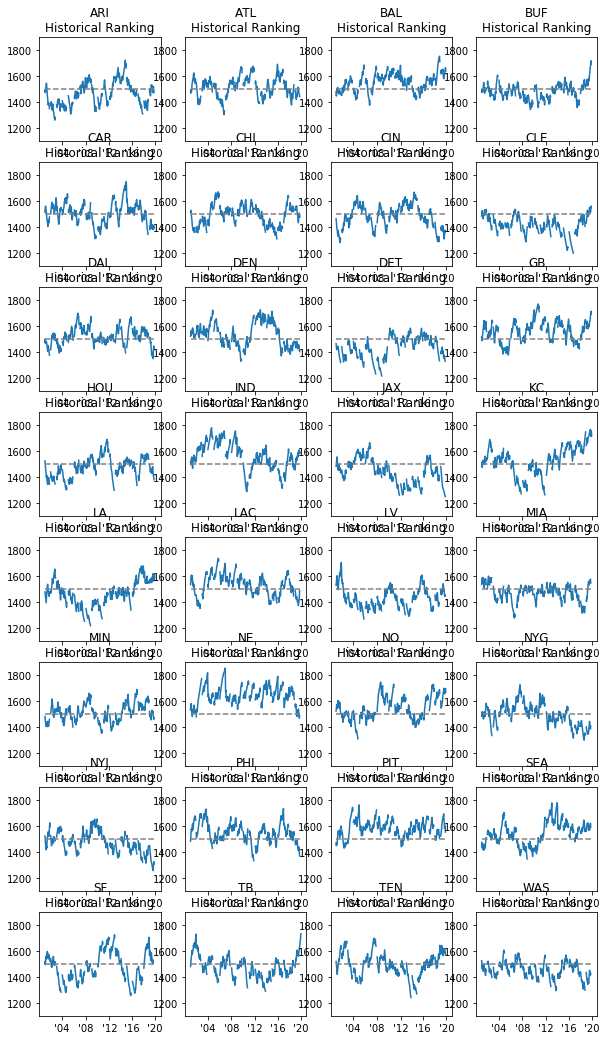

In [8]:
ticks = [58.0,137.0,216.0,292.0,369.0]

fig, axs = plt.subplots(8,4)
fig.set_size_inches(10, 18)

j = -1
for i in range(len(game_elo_df.columns)):
    if i%4 == 0:
        j+=1
    game_elo_df[game_elo_df.columns.sort_values()[i]].plot(ax = axs[j,i%4])
    axs[j, i%4].set_title(game_elo_df.columns.sort_values()[i] + '\nHistorical Ranking')
    axs[j, i%4].set_ylim(1100,1900)
    axs[j, i%4].xaxis.set_ticks(ticks)
    axs[j, i%4].set_xticklabels(["'04", "'08", "'12", "'16", "'20"])
    axs[j, i%4].plot(game_elo_df.index, [1500 for i in game_elo_df.index],'--', color='#808080')
plt.tight_layout()
plt.savefig('nfl_elo_vis_top.png')

### Interactive plotting

In [ ]:
team_dict = {'NYG': 'New York Giants', 'BUF': 'Buffalo Bills', 'CAR': 'Carolina Panthers',
             'CHI': 'Chicago Bears', 'CIN': 'Cincinatti Bengals', 'CLE': 'Cleveland Browns', 'GB':'Green Bay Packers',
             'JAX': 'Jacksonville Jaguars', 'MIA': 'Miami Doplhins','TEN':'Tennessee Titans',
             'WAS':'Washington Football Team', 'DEN':'Denver Broncos', 'LV': 'Las Vegas Raiders', 
             'TB': 'Tampa Bay Buccaneers', 'HOU': 'Houston Texans', 'NE': 'New England Patriots', 'ATL': 'Atlanta Falcons',
             'BAL': 'Baltimore Ravens', 'DAL': 'Dallas Cowboys','IND':'Indianapolis Colts', 
             'KC':'Kansas City Chiefs', 'NO': 'New Orleans Saints', 'NYJ':'New York Jets', 
             'SEA': 'Seattle Seahawks', 'LA': 'Los Angeles Rams', 'MIN': 'Minnesota Vikings', 
             'LAC':'Los Angeles Chargers', 'SF': 'San Francisco 49ers', 'PIT': 'Pittsburgh Steelers',
             'PHI': 'Philadelphia Eagles', 'ARI': 'Arizona Cardinals', 'DET': 'Detroit Lions'
}

In [ ]:
team_color_dict = {'NYG': "rgb(25, 46, 108)",
                   'BUF': 'rgb(0, 51, 141)',
                   'CAR': 'rgb(0, 133, 202)',
                   'CHI': 'rgb(242, 101, 34)', 
                   'CIN': 'rgb(251, 79, 20)',
                   'CLE': 'rgb(255, 60,0)',
                   'GB': 'rgb(36, 66, 60)',
                   'JAX': 'rgb(19, 102, 119)',
                   'MIA': 'rgb(0, 145, 160)',
                   'TEN':'rgb(75, 146, 219)',
                   'WAS':'rgb(124, 20, 21)',
                   'DEN':'rgb(0, 34, 68)',
                   'LV': 'rgb(0, 0, 0)', 
                   'TB': 'rgb(212, 9, 9)',
                   'HOU': 'rgb(0, 20, 63)',
                   'NE': 'rgb(10, 35, 66)',
                   'ATL': 'rgb(167, 25, 48)',
                   'BAL': 'rgb(36, 23, 115)',
                   'DAL': 'rgb(12, 38, 76)',
                   'IND':'rgb(0, 61, 121)', 
                   'KC':'rgb(202, 36, 48)', 
                   'NO': 'rgb(160, 138, 88)', 
                   'NYJ':'rgb(32, 55, 49)', 
                   'SEA': 'rgb(0, 42, 92)', 
                   'LA': 'rgb(149, 119, 76)', 
                   'MIN': 'rgb(79, 46, 132)', 
                   'LAC':'rgb(10, 35, 66)', 
                   'SF': 'rgb(201, 36, 63)', 
                   'PIT': 'rgb(0,0,0)',
                   'PHI': 'rgb(0, 76, 84)', 
                   'ARI': "rgb(151,35,63)",
                   'DET': 'rgb(4, 110, 180)'
}

In [ ]:
a= .15
team_sec_color_dict = {'NYG': 'rgba(163, 13, 45,{0})'.format(a),
                   'BUF': 'rgba(198, 12, 48 ,{0})'.format(a),
                   'CAR': 'rgba(16, 24, 32 ,{0})'.format(a),
                   'CHI': 'rgba(0, 20, 63,{0})'.format(a), 
                   'CIN': 'rgba(0, 0, 0 ,{0})'.format(a),
                   'CLE': 'rgba(255, 60, 0 ,{0})'.format(a),
                   'GB': 'rgba(255, 184, 28 ,{0})'.format(a),
                   'JAX': 'rgba(215, 162, 42 ,{0})'.format(a),
                   'MIA': 'rgba(255, 133, 0 ,{0})'.format(a),
                   'TEN':'rgba(75, 146, 219 ,{0})'.format(a),
                   'WAS':'rgba(255,182,18 ,{0})'.format(a),
                   'DEN':'rgba(251, 79, 2 ,{0})'.format(a),
                   'LV': 'rgba(165, 172, 175 ,{0})'.format(a), 
                   'TB': 'rgba(255, 121, 0 ,{0})'.format(a),
                   'HOU': 'rgba(167, 25, 48 ,{0})'.format(a),
                   'NE': 'rgba(198, 12, 48 ,{0})'.format(a),
                   'ATL': 'rgba(10, 0, 0 ,{0})'.format(a),
                   'BAL': 'rgba(0, 0, 0 ,{0})'.format(a),
                   'DAL': 'rgba(0, 34, 68 ,{0})'.format(a),
                   'IND':'rgba(162, 170, 173 ,{0})'.format(a), 
                   'KC':'rgba(255, 184, 28 ,{0})'.format(a), 
                   'NO': 'rgba(16, 24, 31 ,{0})'.format(a), 
                   'NYJ':'rgba(0, 0, 0 ,{0})'.format(a), 
                   'SEA': 'rgba(105, 190, 40 ,{0})'.format(a), 
                   'LA': 'rgba(0, 33, 71 ,{0})'.format(a), 
                   'MIN': 'rgba(79, 46, 132 ,{0})'.format(a), 
                   'LAC':'rgba(255, 194, 14 ,{0})'.format(a), 
                   'SF': 'rgba(173, 153, 93 ,{0})'.format(a), 
                   'PIT': 'rgba(255, 194, 14 ,{0})'.format(a),
                   'PHI': 'rgba(165, 172, 175 ,{0})'.format(a), 
                   'ARI': "rgba(0,0,0 ,{0})".format(a), 
                   'DET': 'rgba(176, 183, 188 ,{0})'.format(a) 
}

In [ ]:
games_df = pd.read_csv('data/nfl_game_data.csv')
home_adv = 0
margin_div = 1
season_retain_weight = .5
k_val = 20

class Implementation:
    """
    A class that represents an implementation of the Elo Rating System
    """

    def __init__(self, base_rating=1500):
        """
        Runs at initialization of class object.
        @param base_rating - The rating a new player would have
        """
        self.base_rating = base_rating
        self.players = []

    def __getPlayerList(self):
        """
        Returns this implementation's player list.
        @return - the list of all player objects in the implementation.
        """
        return self.players

    def getPlayer(self, name):
        """
        Returns the player in the implementation with the given name.
        @param name - name of the player to return.
        @return - the player with the given name.
        """
        for player in self.players:
            if player.name == name:
                return player
        return None

    def contains(self, name):
        """
        Returns true if this object contains a player with the given name.
        Otherwise returns false.
        @param name - name to check for.
        """
        for player in self.players:
            if player.name == name:
                return True
        return False

    def addPlayer(self, name, rating=None):
        """
        Adds a new player to the implementation.
        @param name - The name to identify a specific player.
        @param rating - The player's rating.
        """
        if rating == None:
            rating = self.base_rating

        self.players.append(_Player(name=name,rating=rating))

    def removePlayer(self, name):
        """
        Adds a new player to the implementation.
        @param name - The name to identify a specific player.
        """
        self.__getPlayerList().remove(self.getPlayer(name))


    def recordMatch(self, name1, name2, winner=None, draw=False, margin=None):
        """
        Should be called after a game is played.
        @param name1 - name of the first player.
        @param name2 - name of the second player.
        """
        player1 = self.getPlayer(name1)
        player2 = self.getPlayer(name2)

        expected1 = player1.compareRating(player2, home = True)
        expected2 = player2.compareRating(player1, home = False)

        k = k_val

        rating1 = player1.rating
        rating2 = player2.rating

        if draw:
            score1 = 0.5
            score2 = 0.5
        elif winner == name1:
            score1 = 1.0
            score2 = 0.0
        elif winner == name2:
            score1 = 0.0
            score2 = 1.0
        else:
            raise InputError('One of the names must be the winner or draw must be True')

        if draw:
            newRating1 = rating1 + k * (score1 - expected1)
            newRating2 = rating2 + k * (score2 - expected2)
        else:
            newRating1 = rating1 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score1 - expected1)
            newRating2 = rating2 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score2 - expected2)


        if newRating1 < 0:
            newRating1 = 0
            newRating2 = rating2 - rating1

        elif newRating2 < 0:
            newRating2 = 0
            newRating1 = rating1 - rating2

        player1.rating = newRating1
        player2.rating = newRating2

    def getPlayerRating(self, name):
        """
        Returns the rating of the player with the given name.
        @param name - name of the player.
        @return - the rating of the player with the given name.
        """
        player = self.getPlayer(name)
        return player.rating

    def getRatingList(self):
        """
        Returns a list of tuples in the form of ({name},{rating})
        @return - the list of tuples
        """
        lst = []
        for player in self.__getPlayerList():
            lst.append((player.name,player.rating))
        return lst

class _Player:
    """
    A class to represent a player in the Elo Rating System
    """

    def __init__(self, name, rating):
        """
        Runs at initialization of class object.
        @param name - TODO
        @param rating - TODO
        """
        self.name = name
        self.rating = rating

    def compareRating(self, opponent, home):
        """
        Compares the two ratings of the this player and the opponent.
        @param opponent - the player to compare against.
        @returns - The expected score between the two players.
        """
        if home == True:
            return ( 1+10**( ( opponent.rating-self.rating-home_adv )/400.0 ) ) ** -1
        else:
            return ( 1+10**( ( opponent.rating-self.rating+home_adv )/400.0 ) ) ** -1

games_count_df = pd.DataFrame(columns=games_df.home.unique())
games_count_df.loc[0] = [0 for col in games_count_df.columns]

game_elo_df = pd.DataFrame(columns=games_df.home.unique())

uni = Implementation()


for team in games_df.home.unique():
    uni.addPlayer(name = team)

total = 0
correct = 0
for season in games_df.year.unique():
    for week in games_df.week.unique():
        for ind in games_df[(games_df.year==season) & (games_df.week==week)].index:
            home = games_df.loc[ind, 'home']
            away = games_df.loc[ind, 'away']

            home_elo = uni.getPlayerRating(home)
            away_elo = uni.getPlayerRating(away)
            if home_elo > away_elo:
                pred = home
            else:
                pred = away

            games_count_df.loc[0, home] = games_count_df.loc[0, home]+1
            games_count_df.loc[0, away] = games_count_df.loc[0, away]+1

            margin = games_df.loc[ind, 'home_pts'] - games_df.loc[ind, 'away_pts']

            if margin > 0:
                winner = home
            elif margin < 0:
                winner = away
                margin *= -1
            else:
                winner = 'tie'

            if winner == 'tie':
                uni.recordMatch(home, away, draw=True)
            else:
                uni.recordMatch(home, away, winner, margin=margin)

            total += 1
            if pred == winner:
                correct += 1

            game_elo_df.loc[games_count_df.loc[0, home], home] = uni.getPlayerRating(home)
            game_elo_df.loc[games_count_df.loc[0, away], away] = uni.getPlayerRating(away)

    games_count_df.loc[0] = [games_count_df.max().max() for col in games_count_df.columns]

    for team in games_df.home.unique():
            uni.getPlayer(team).rating = (season_retain_weight * uni.getPlayerRating(team)) +\
                ((1-season_retain_weight) * 1500)

In [ ]:
data_cols = list(game_elo_df.columns.sort_values())

pick_col = widgets.Dropdown(
    options=data_cols,
    description='Team',
)

In [10]:
def create_historical_view(team):
    label_dict = pd.concat([pd.Series(game_elo_df[team][game_elo_df[team].notnull()].index), 
           pd.Series(list(zip(games_df[(games_df.home==team) | (games_df.away==team)].week,
                games_df[(games_df.home==team) | (games_df.away==team)].year))).\
                apply(lambda x: 'Week {0} of {1} Season'.format(x[0], x[1])).reset_index(drop=True)], 
           axis = 1).set_index(0).to_dict()[1]

    game_elo_df['temp_labels'] = game_elo_df[team].index.map(label_dict)
    
    fig = px.line(game_elo_df,
                  x = 'temp_labels',
                  y=team,
                  width=600,
                  height=600,
                  labels={
                     team: "Elo rating",
                     "temp_labels": "Point in time"
                 },
                 title="NFL Historical Ratings<br><sup>Using Elo framework to establish historical rankings for NFL teams</sup>",
                 color_discrete_sequence = [team_color_dict[team]]
                 )
    
    fig.update_layout(font_family="Arial",
                      font_color='rgb(0,0,0)',
                      plot_bgcolor= team_sec_color_dict['DET'],
                     xaxis = dict(
                         title = '',
                        tickmode = 'array',
                        tickvals = ['Week 1 of 2004 Season', 'Week 1 of 2006 Season',
                                   'Week 1 of 2008 Season', 'Week 1 of 2010 Season', 'Week 1 of 2012 Season',
                                   'Week 1 of 2014 Season', 'Week 1 of 2016 Season', 'Week 1 of 2018 Season',
                                   'Week 1 of 2020 Season'],
                        ticktext = ["'04", "'06", "'08", "'10", "'12", "'14", "'16", "'18", "'20"],
                     rangeslider=dict(
                            visible = True
                        )),
                     yaxis=dict(
                        title ='',
                        range=[1100,1900])
                     )
    
    fig.add_shape(type="line",
        x0=0, y0=1500, x1=len(game_elo_df[team].dropna()), y1=1500,
        line=dict(color='rgb(0,0,0)',width=1, dash="dot")
    )
    
    fig.show()
    
    game_elo_df['temp_labels'] = None

widgets.interact(create_historical_view, team=pick_col);

interactive(children=(Dropdown(description='Team', options=('ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', '…

### Monte carlo for 2022 Super Bowl

In [ ]:
sched = pd.read_excel('data/2021_schedule.xlsx')
sched = sched.set_index('TEAM')
sched.head(6)

In [9]:
sb_ct_df = pd.DataFrame(columns = sched.index)
sb_ct_df.loc[0] = [0 for col in sb_ct_df.columns]

for trial in range(1000):
    temp = game_elo_df.apply(lambda x: x[x.notnull()].tail(1))
    elo_2021_df = pd.DataFrame(temp.fillna(0).sum())
    elo_2021_df = elo_2021_df.drop('temp_labels', axis = 0)
    elo_2021_df.columns = ['ELO']
    elo_2021_df['wins'] = 0
    elo_2021_df['losses'] = 0
    elo_2021_df['ELO'] = (elo_2021_df['ELO']*.5) + (1500 * .5)
    
    uni = Implementation()

    for team in sched.index:
        uni.addPlayer(team, elo_2021_df.loc[team, 'ELO'])

    # regular season
    for week in sched.columns: 
        matches = []
        for team in sched.index:
            opp = sched.loc[team, week]
            if (opp != 'BYE') & ((opp, team) not in matches):
                matches.append((team, opp))
                player = uni.getPlayer(team)
                oppo = uni.getPlayer(opp)
                odds = player.compareRating(oppo, False)

                if np.random.choice([1,0], p=[odds, 1-odds]):
                    uni.recordMatch(team, opp, team, 1)
                    elo_2021_df.loc[team, 'wins'] = elo_2021_df.loc[team, 'wins']  + 1
                    elo_2021_df.loc[opp, 'losses'] = elo_2021_df.loc[opp, 'losses']  + 1
                else:
                    uni.recordMatch(team, opp, opp, 1)
                    elo_2021_df.loc[opp, 'wins'] = elo_2021_df.loc[opp, 'wins']  + 1
                    elo_2021_df.loc[team, 'losses'] = elo_2021_df.loc[team, 'losses']  + 1
    for team in sched.index:
        elo_2021_df.loc[team, 'ELO'] = uni.getPlayer(team).rating

    elo_2021_df= elo_2021_df.sort_index()

    elo_2021_df['Conference'] = ['NFC', 'NFC', 'AFC', 'AFC', 'NFC', 'NFC', 'AFC', 'AFC',
                                 'NFC', 'AFC', 'NFC', 'NFC', 'AFC', 'AFC', 'AFC', 'AFC',
                                 'NFC', 'AFC', 'AFC', 'AFC', 'NFC', 'AFC', 'NFC', 'NFC',
                                 'AFC', 'NFC', 'AFC', 'NFC', 'NFC', 'NFC', 'AFC', 'NFC']

    elo_2021_df['Div'] = ['W', 'S', 'N', 'E', 'S', 'N', 'N', 'N',
                          'E', 'W', 'N', 'N', 'S', 'S', 'S', 'W',
                          'W', 'W', 'W', 'E', 'N', 'E', 'S', 'E',
                          'E', 'E', 'N', 'W', 'W', 'S', 'S', 'E']

    # elo_2021_df.groupby('Conference').Div.value_counts()

    div_champs = elo_2021_df.sort_values('wins', ascending = False).\
        groupby(['Conference', 'Div']).head(1).copy()
    div_champs = div_champs.sort_values(['Conference', 'wins'], ascending = [False, False])
    div_champs['seed'] = [1,2,3,4,1,2,3,4]

    wild_cards = elo_2021_df[~elo_2021_df.index.isin(div_champs.index)].\
        sort_values('wins', ascending = False).\
        groupby(['Conference']).head(3)

    wild_cards = wild_cards.sort_values(['Conference', 'wins'], ascending = [False, False])
    wild_cards['seed'] = [5,6,7,5,6,7]

    playoff_teams = pd.concat([div_champs, wild_cards])
    playoff_teams[playoff_teams.Conference == 'NFC']

    #NFC
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 4) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 5) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ################################
    player = uni.getPlayer(NFC_1_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 1) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 3) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 6) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 2) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 7) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_3_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_3_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(NFC_2_winner)
    oppo = uni.getPlayer(NFC_3_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(NFC_1_winner)
    oppo = uni.getPlayer(NFC_2_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    # AFC
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 4) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 5) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ################################
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 1) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 3) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 6) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 2) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 7) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_3_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_3_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(AFC_2_winner)
    oppo = uni.getPlayer(AFC_3_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(AFC_2_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    # SUPERBOWL
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(NFC_1_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        SBC = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        SBC = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    sb_ct_df[SBC] = sb_ct_df[SBC] + 1

NameError: name 'sched' is not defined

#### Preliminary 2022 SBC probabilities

In [255]:
sb_ct_df_22 = sb_ct_df.T.div(
    sb_ct_df.T.sum()
).sort_values(0,ascending=False).head(15)
sb_ct_df_22

,0
TEAM,
TB,0.099
KC,0.09
BUF,0.085
NO,0.072
GB,0.07
BAL,0.065
SEA,0.064
IND,0.045
TEN,0.044


### Backtest 2021 SBC predictions

In [256]:
sched = pd.read_excel('data/2020_schedule.xlsx')
sched = sched.set_index('TEAM')
sched.head(6)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
TEAM,,,,,,,,,,,,,,,,,
ARI,SF,WAS,DET,CAR,NYJ,DAL,SEA,BYE,MIA,BUF,SEA,NE,LA,NYG,PHI,SF,LA
ATL,SEA,DAL,CHI,GB,CAR,MIN,DET,CAR,DEN,BYE,NO,LV,NO,LAC,TB,KC,TB
BAL,CLE,HOU,KC,WAS,CIN,PHI,BYE,PIT,IND,NE,TEN,PIT,DAL,CLE,JAX,NYG,CIN
BUF,NYJ,MIA,LA,LV,TEN,KC,NYJ,NE,SEA,ARI,BYE,LAC,SF,PIT,DEN,NE,MIA
CAR,LV,TB,LAC,ARI,ATL,CHI,NO,ATL,KC,TB,DET,MIN,BYE,DEN,GB,WAS,NO
CHI,DET,NYG,ATL,IND,TB,CAR,LA,NO,TEN,MIN,BYE,GB,DET,HOU,MIN,JAX,GB


In [257]:
sb_ct_df = pd.DataFrame(columns = sched.index)
sb_ct_df.loc[0] = [0 for col in sb_ct_df.columns]

for trial in range(1000):
    temp = game_elo_df.loc[:349,:].apply(lambda x: x[x.notnull()].tail(1))
    elo_2020_df = pd.DataFrame(temp.fillna(0).sum())
    elo_2020_df = elo_2020_df.drop('temp_labels', axis = 0)
    elo_2020_df.columns = ['ELO']
    elo_2020_df['wins'] = 0
    elo_2020_df['losses'] = 0
    elo_2020_df['ELO'] = (elo_2020_df['ELO']*.5) + (1500 * .5)
    
    uni = Implementation()

    for team in sched.index:
        uni.addPlayer(team, elo_2020_df.loc[team, 'ELO'])

    # regular season
    for week in sched.columns: 
        matches = []
        for team in sched.index:
            opp = sched.loc[team, week]
            if (opp != 'BYE') & ((opp, team) not in matches):
                matches.append((team, opp))
                player = uni.getPlayer(team)
                oppo = uni.getPlayer(opp)
                odds = player.compareRating(oppo, False)

                if np.random.choice([1,0], p=[odds, 1-odds]):
                    uni.recordMatch(team, opp, team, 1)
                    elo_2020_df.loc[team, 'wins'] = elo_2020_df.loc[team, 'wins']  + 1
                    elo_2020_df.loc[opp, 'losses'] = elo_2020_df.loc[opp, 'losses']  + 1
                else:
                    uni.recordMatch(team, opp, opp, 1)
                    elo_2020_df.loc[opp, 'wins'] = elo_2020_df.loc[opp, 'wins']  + 1
                    elo_2020_df.loc[team, 'losses'] = elo_2020_df.loc[team, 'losses']  + 1
    for team in sched.index:
        elo_2020_df.loc[team, 'ELO'] = uni.getPlayer(team).rating

    elo_2020_df= elo_2020_df.sort_index()

    elo_2020_df['Conference'] = ['NFC', 'NFC', 'AFC', 'AFC', 'NFC', 'NFC', 'AFC', 'AFC',
                                 'NFC', 'AFC', 'NFC', 'NFC', 'AFC', 'AFC', 'AFC', 'AFC',
                                 'NFC', 'AFC', 'AFC', 'AFC', 'NFC', 'AFC', 'NFC', 'NFC',
                                 'AFC', 'NFC', 'AFC', 'NFC', 'NFC', 'NFC', 'AFC', 'NFC']

    elo_2020_df['Div'] = ['W', 'S', 'N', 'E', 'S', 'N', 'N', 'N',
                          'E', 'W', 'N', 'N', 'S', 'S', 'S', 'W',
                          'W', 'W', 'W', 'E', 'N', 'E', 'S', 'E',
                          'E', 'E', 'N', 'W', 'W', 'S', 'S', 'E']

    # elo_2020_df.groupby('Conference').Div.value_counts()

    div_champs = elo_2020_df.sort_values('wins', ascending = False).\
        groupby(['Conference', 'Div']).head(1).copy()
    div_champs = div_champs.sort_values(['Conference', 'wins'], ascending = [False, False])
    div_champs['seed'] = [1,2,3,4,1,2,3,4]

    wild_cards = elo_2020_df[~elo_2020_df.index.isin(div_champs.index)].\
        sort_values('wins', ascending = False).\
        groupby(['Conference']).head(3)

    wild_cards = wild_cards.sort_values(['Conference', 'wins'], ascending = [False, False])
    wild_cards['seed'] = [5,6,7,5,6,7]

    playoff_teams = pd.concat([div_champs, wild_cards])
    playoff_teams[playoff_teams.Conference == 'NFC']

    #NFC
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 4) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 5) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ################################
    player = uni.getPlayer(NFC_1_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 1) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 3) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 6) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 2) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 7) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_3_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_3_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(NFC_2_winner)
    oppo = uni.getPlayer(NFC_3_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(NFC_1_winner)
    oppo = uni.getPlayer(NFC_2_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    # AFC
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 4) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 5) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ################################
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 1) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 3) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 6) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 2) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 7) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_3_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_3_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(AFC_2_winner)
    oppo = uni.getPlayer(AFC_3_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(AFC_2_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    # SUPERBOWL
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(NFC_1_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        SBC = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        SBC = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    sb_ct_df[SBC] = sb_ct_df[SBC] + 1

#### Initial estimated 2021 SBC probabilities

In [262]:
sb_ct_df_21 = sb_ct_df.T.div(
    sb_ct_df.T.sum()
).sort_values(0,ascending=False)
sb_ct_df_21

,0
TEAM,
BAL,0.114
KC,0.113
SF,0.082
NO,0.074
TEN,0.058
NE,0.055
GB,0.052
MIN,0.047
SEA,0.037


### Backtest 2020 SBC predictions

In [263]:
sched = pd.read_excel('data/2019_schedule.xlsx')
sched = sched.set_index('TEAM')
sched.head(6)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
TEAM,,,,,,,,,,,,,,,,,
ARI,DET,BAL,CAR,SEA,CIN,ATL,NYG,NO,SF,TB,SF,BYE,LA,PIT,CLE,SEA,LA
ATL,MIN,PHI,IND,TEN,HOU,ARI,LA,SEA,BYE,NO,CAR,TB,NO,CAR,SF,JAX,TB
BAL,MIA,ARI,KC,CLE,PIT,CIN,SEA,BYE,NE,CIN,HOU,LA,SF,BUF,NYJ,CLE,PIT
BUF,NYJ,NYG,CIN,NE,TEN,BYE,MIA,PHI,WAS,CLE,MIA,DEN,DAL,BAL,PIT,NE,NYJ
CAR,LA,TB,ARI,HOU,JAX,TB,BYE,SF,TEN,GB,ATL,NO,WAS,ATL,SEA,IND,NO
CHI,GB,DEN,WAS,MIN,LV,BYE,NO,LAC,PHI,DET,LA,NYG,DET,DAL,GB,KC,MIN


In [264]:
sb_ct_df = pd.DataFrame(columns = sched.index)
sb_ct_df.loc[0] = [0 for col in sb_ct_df.columns]

for trial in range(1000):
    temp = game_elo_df.loc[:330,:].apply(lambda x: x[x.notnull()].tail(1))
    elo_2019_df = pd.DataFrame(temp.fillna(0).sum())
    elo_2019_df = elo_2019_df.drop('temp_labels', axis = 0)
    elo_2019_df.columns = ['ELO']
    elo_2019_df['wins'] = 0
    elo_2019_df['losses'] = 0
    elo_2019_df['ELO'] = (elo_2019_df['ELO']*.5) + (1500 * .5)
    
    uni = Implementation()

    for team in sched.index:
        uni.addPlayer(team, elo_2019_df.loc[team, 'ELO'])

    # regular season
    for week in sched.columns: 
        matches = []
        for team in sched.index:
            opp = sched.loc[team, week]
            if (opp != 'BYE') & ((opp, team) not in matches):
                matches.append((team, opp))
                player = uni.getPlayer(team)
                oppo = uni.getPlayer(opp)
                odds = player.compareRating(oppo, False)

                if np.random.choice([1,0], p=[odds, 1-odds]):
                    uni.recordMatch(team, opp, team, 1)
                    elo_2019_df.loc[team, 'wins'] = elo_2019_df.loc[team, 'wins']  + 1
                    elo_2019_df.loc[opp, 'losses'] = elo_2019_df.loc[opp, 'losses']  + 1
                else:
                    uni.recordMatch(team, opp, opp, 1)
                    elo_2019_df.loc[opp, 'wins'] = elo_2019_df.loc[opp, 'wins']  + 1
                    elo_2019_df.loc[team, 'losses'] = elo_2019_df.loc[team, 'losses']  + 1
    for team in sched.index:
        elo_2019_df.loc[team, 'ELO'] = uni.getPlayer(team).rating

    elo_2019_df= elo_2019_df.sort_index()

    elo_2019_df['Conference'] = ['NFC', 'NFC', 'AFC', 'AFC', 'NFC', 'NFC', 'AFC', 'AFC',
                                 'NFC', 'AFC', 'NFC', 'NFC', 'AFC', 'AFC', 'AFC', 'AFC',
                                 'NFC', 'AFC', 'AFC', 'AFC', 'NFC', 'AFC', 'NFC', 'NFC',
                                 'AFC', 'NFC', 'AFC', 'NFC', 'NFC', 'NFC', 'AFC', 'NFC']

    elo_2019_df['Div'] = ['W', 'S', 'N', 'E', 'S', 'N', 'N', 'N',
                          'E', 'W', 'N', 'N', 'S', 'S', 'S', 'W',
                          'W', 'W', 'W', 'E', 'N', 'E', 'S', 'E',
                          'E', 'E', 'N', 'W', 'W', 'S', 'S', 'E']

    # elo_2019_df.groupby('Conference').Div.value_counts()

    div_champs = elo_2019_df.sort_values('wins', ascending = False).\
        groupby(['Conference', 'Div']).head(1).copy()
    div_champs = div_champs.sort_values(['Conference', 'wins'], ascending = [False, False])
    div_champs['seed'] = [1,2,3,4,1,2,3,4]

    wild_cards = elo_2019_df[~elo_2019_df.index.isin(div_champs.index)].\
        sort_values('wins', ascending = False).\
        groupby(['Conference']).head(2)

    wild_cards = wild_cards.sort_values(['Conference', 'wins'], ascending = [False, False])
    wild_cards['seed'] = [5,6,5,6]

    playoff_teams = pd.concat([div_champs, wild_cards])
    playoff_teams[playoff_teams.Conference == 'NFC']

    #NFC
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 4) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 5) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ################################
    player = uni.getPlayer(NFC_1_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 2) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 3) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 6) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
################################################################
    player = uni.getPlayer(NFC_2_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 1) &\
                                    (playoff_teams.Conference == 'NFC')].index.values)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(NFC_1_winner)
    oppo = uni.getPlayer(NFC_2_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        NFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        NFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    #AFC
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 4) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 5) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ################################
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 2) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    ###################################
    player = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 3) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 6) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)

    odds = player.compareRating(oppo, False)

    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
################################################################
    player = uni.getPlayer(AFC_2_winner)
    oppo = uni.getPlayer(playoff_teams.loc[(playoff_teams.seed == 1) &\
                                    (playoff_teams.Conference == 'AFC')].index.values)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_2_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_2_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    ########################################
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(AFC_2_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        AFC_1_winner = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        AFC_1_winner = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)

    # SUPERBOWL
    player = uni.getPlayer(AFC_1_winner)
    oppo = uni.getPlayer(NFC_1_winner)
    odds = player.compareRating(oppo, False)
    if np.random.choice([1,0], p=[odds, 1-odds]):
        SBC = player.name
        uni.recordMatch(player.name, oppo.name, player.name, 1)
    else:
        SBC = oppo.name
        uni.recordMatch(player.name, oppo.name, oppo.name, 1)
    sb_ct_df[SBC] = sb_ct_df[SBC] + 1

#### Initial estimated 2020 SBC probabilities

In [265]:
sb_ct_df_20 = sb_ct_df.T.div(
    sb_ct_df.T.sum()
).sort_values(0,ascending=False)
sb_ct_df_20

,0
TEAM,
NE,0.125
LA,0.083
NO,0.082
KC,0.064
PHI,0.06
CHI,0.058
BAL,0.053
PIT,0.05
LAC,0.049
